## Setup

Recomendações de Hiperparâmetros para o Ajuste Fino (Fine-tuning) do BERT
Recomendações dos autores do BERT para a escolha dos principais hiperparâmetros durante o processo de ajuste fino, conforme descrito no artigo original:

Tamanho do Lote (Batch size): 16 ou 32.

Taxa de Aprendizagem (Learning rate): Para o otimizador AdamW, valores ideais geralmente estão na faixa:

5×10
−5
 , 3×10
−5
  ou 2×10
−5.

5e-5, 3e-5 ou 2e-5

Número de Épocas (Epochs): O treinamento é tipicamente executado por 2, 3 ou 4 épocas, pois um número maior pode levar a um overfitting rapidamente.

É crucial notar a relação inversa entre o tamanho do lote e a precisão do modelo. Embora lotes maiores possam acelerar o tempo de treinamento (utilizando mais a capacidade da GPU), eles podem levar a uma precisão ligeiramente inferior, pois o modelo tem menos oportunidades de atualizar seus pesos com base em diferentes subconjuntos de dados. Para otimizar a generalização, lotes menores (como 16) são frequentemente preferidos.

In [119]:
# Instalar PyTorch, TorchVision e Torchaudio
!pip install torch torchvision torchaudio

# Instalar outras bibliotecas necessárias
!pip install transformers==4.29.2 numpy pandas seaborn matplotlib scikit-learn

# Instalar o watermark para exibir versões das bibliotecas
!pip install -U watermark

In [120]:
%reload_ext watermark

# Exibir versões das bibliotecas
%watermark -v -p numpy,pandas,torch,transformers

Python implementation: CPython
Python version       : 3.11.0
IPython version      : 9.5.0

numpy       : 2.3.3
pandas      : 2.3.2
torch       : 2.8.0
transformers: 4.29.2



In [121]:
!nvidia-smi

Tue Sep 16 14:26:59 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 581.15                 Driver Version: 581.15         CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce GTX 1650      WDDM  |   00000000:01:00.0  On |                  N/A |
| N/A   42C    P8              4W /   50W |     741MiB /   4096MiB |     21%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
# A partir da biblioteca Transformers da Hugging Face, importando as classes
import transformers
from transformers import AutoModel  # ou AutoModel, para carregar o modelo BERT
from transformers import (
    AutoTokenizer,
)  # ou AutoTokenizer, para carregar o tokenizador BERT
from transformers import (
    get_linear_schedule_with_warmup,
)  # Para controle do agendamento da taxa de aprendizado

# Importando a biblioteca PyTorch
import torch
from torch.optim import AdamW  # Para otimização do modelo
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import numpy as np
import pandas as pd

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

from collections import defaultdict
from textwrap import wrap

import os
# from google.colab import files

from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

import warnings

warnings.filterwarnings("ignore")

%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style="whitegrid", palette="viridis", font_scale=1.2)
HAPPY_COLORS_PALETTE = [
    "#01BEFE",
    "#FFDD00",
    "#FF7D00",
    "#FF006D",
    "#ADFF02",
    "#8F00FF",
]
rcParams["figure.figsize"] = 12, 8
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Modelos
BERTimbauBase = "neuralmind/bert-base-portuguese-cased"
BERTimbauLarge = "neuralmind/bert-large-portuguese-cased"
BERMultilingualBase = (
    "google-bert/bert-base-multilingual-cased"  # Modelo BERT multilíngue do Google
)
XLMRobertaBase = "FacebookAI/xlm-roberta-base"  # Modelo XLM-RoBERTa é uma versão multilíngue do RoBERTa.

PRE_TRAINED_MODEL_NAME = BERTimbauBase

# Carregando o modelo BERTimbau da Hugging Face pré-treinado em português
baseModel = AutoModel.from_pretrained(PRE_TRAINED_MODEL_NAME, return_dict=False)

# Carregando o tokenizador BERTimbau da Hugging Face pré-treinado em português
tokenizer = AutoTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

# Configuração de treino
EPOCHS = 10
# Teste e validação terão cada um a metade do TEST_SIZE
TEST_SIZE = 0.3
# Taxa de dropout para regularização, ajudando a prevenir o sobreajuste (overfitting).
DROPOUT = 0.3

# Tamanho do lote "BATCH" (Quantos exemplos um conjunto de dados vai ter)
BATCH_SIZE = 4
# Taxa de aprendizado (Learning Rate) para o otimizador # 2e-5, 3e-5 ou 5e-5
LEARNING_RATE = 2e-5
# Habilita ou desabilita o uso de pesos para balanceamento de classes
CLASS_WEIGHTS = True

dataset_train_name = (
    "3_dataset_reanotado_gemini_2_5_pro_dados_treino_limpeza_demojize.csv"
)

dataset_val_name = (
    "1_dataset_original_colunas_selecionadas_dados_validacao_limpeza_demojize.csv"
)

dataset_test_name = (
    "1_dataset_original_colunas_selecionadas_dados_teste_limpeza_demojize.csv"
)

# score_reanotado_gemini | score (para gpt e dataset original)
score_treino = "score_reanotado_gemini"

score_para_val_teste = "score"


sentiment_column = "sentiment"

class_names = [
    "extremamente negativo",
    "negativo",
    "neutro",
    "positivo",
    "extremamente positivo",
]

Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [130]:
print(f"Classe do modelo carregado: {type(baseModel)}")
print(f"Classe do tokenizer carregado: {type(tokenizer)}")

Classe do modelo carregado: <class 'transformers.models.bert.modeling_bert.BertModel'>
Classe do tokenizer carregado: <class 'transformers.models.bert.tokenization_bert_fast.BertTokenizerFast'>


In [131]:
# Verificando se a GPU com suporte a CUDA está disponível no sistema
torch.cuda.is_available()

False

In [132]:
device

device(type='cpu')

## Manipulação dos dados

## Importação dos dados

In [133]:
# uploaded = files.upload()

In [134]:
df_train = pd.read_csv(dataset_train_name)
df_val = pd.read_csv(dataset_val_name)
df_test = pd.read_csv(dataset_test_name)

print(f"Dataset de treino: {df_train.shape}")
print(f"Dataset de validação: {df_val.shape}")
print(f"Dataset de teste: {df_test.shape}")

Dataset de treino: (2100, 4)
Dataset de validação: (450, 3)
Dataset de teste: (450, 3)


In [135]:
def get_sentiment(rating):
    rating = int(rating)
    if rating == 1:
        return 0
    elif rating == 2:
        return 1
    elif rating == 3:
        return 2
    elif rating == 4:
        return 3
    else:
        return 4


# def get_sentiment(rating):
#     rating = int(rating)
#     if rating <= 2: return 0
#     elif rating == 3: return 1
#     else: return 2

df_train[sentiment_column] = df_train[score_treino].apply(get_sentiment)
df_val[sentiment_column] = df_val[score_para_val_teste].apply(get_sentiment)
df_test[sentiment_column] = df_test[score_para_val_teste].apply(get_sentiment)

In [137]:
df_train.shape  # Tamanho do conjunto de treinamento
df_val.shape  # Tamanho do conjunto de validação
df_test.shape  # Tamanho do conjunto de teste

(2100, 4)

(450, 3)

(450, 3)

In [138]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2100 entries, 0 to 2099
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   content                 2100 non-null   object
 1   score                   2100 non-null   int64 
 2   score_reanotado_gemini  2100 non-null   int64 
 3   sentiment               2100 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 65.8+ KB


In [139]:
print(f"Dataset de treino: {df_train[sentiment_column].value_counts()}")
print(f"Dataset de validação: {df_val[sentiment_column].value_counts()}")
print(f"Dataset de teste: {df_test[sentiment_column].value_counts()}")

Dataset de treino: sentiment
2    666
1    651
0    425
4    225
3    133
Name: count, dtype: int64
Dataset de validação: sentiment
4    97
2    96
1    93
3    86
0    78
Name: count, dtype: int64
Dataset de teste: sentiment
0    96
4    93
1    91
2    86
3    84
Name: count, dtype: int64


<Figure size 1000x600 with 0 Axes>

<Axes: xlabel='sentiment', ylabel='count'>

Text(0.5, 0, 'Sentimento')

Text(0, 0.5, 'Número de Avaliações')

Text(0.5, 1.0, 'Distribuição de Sentimentos por Dataset')

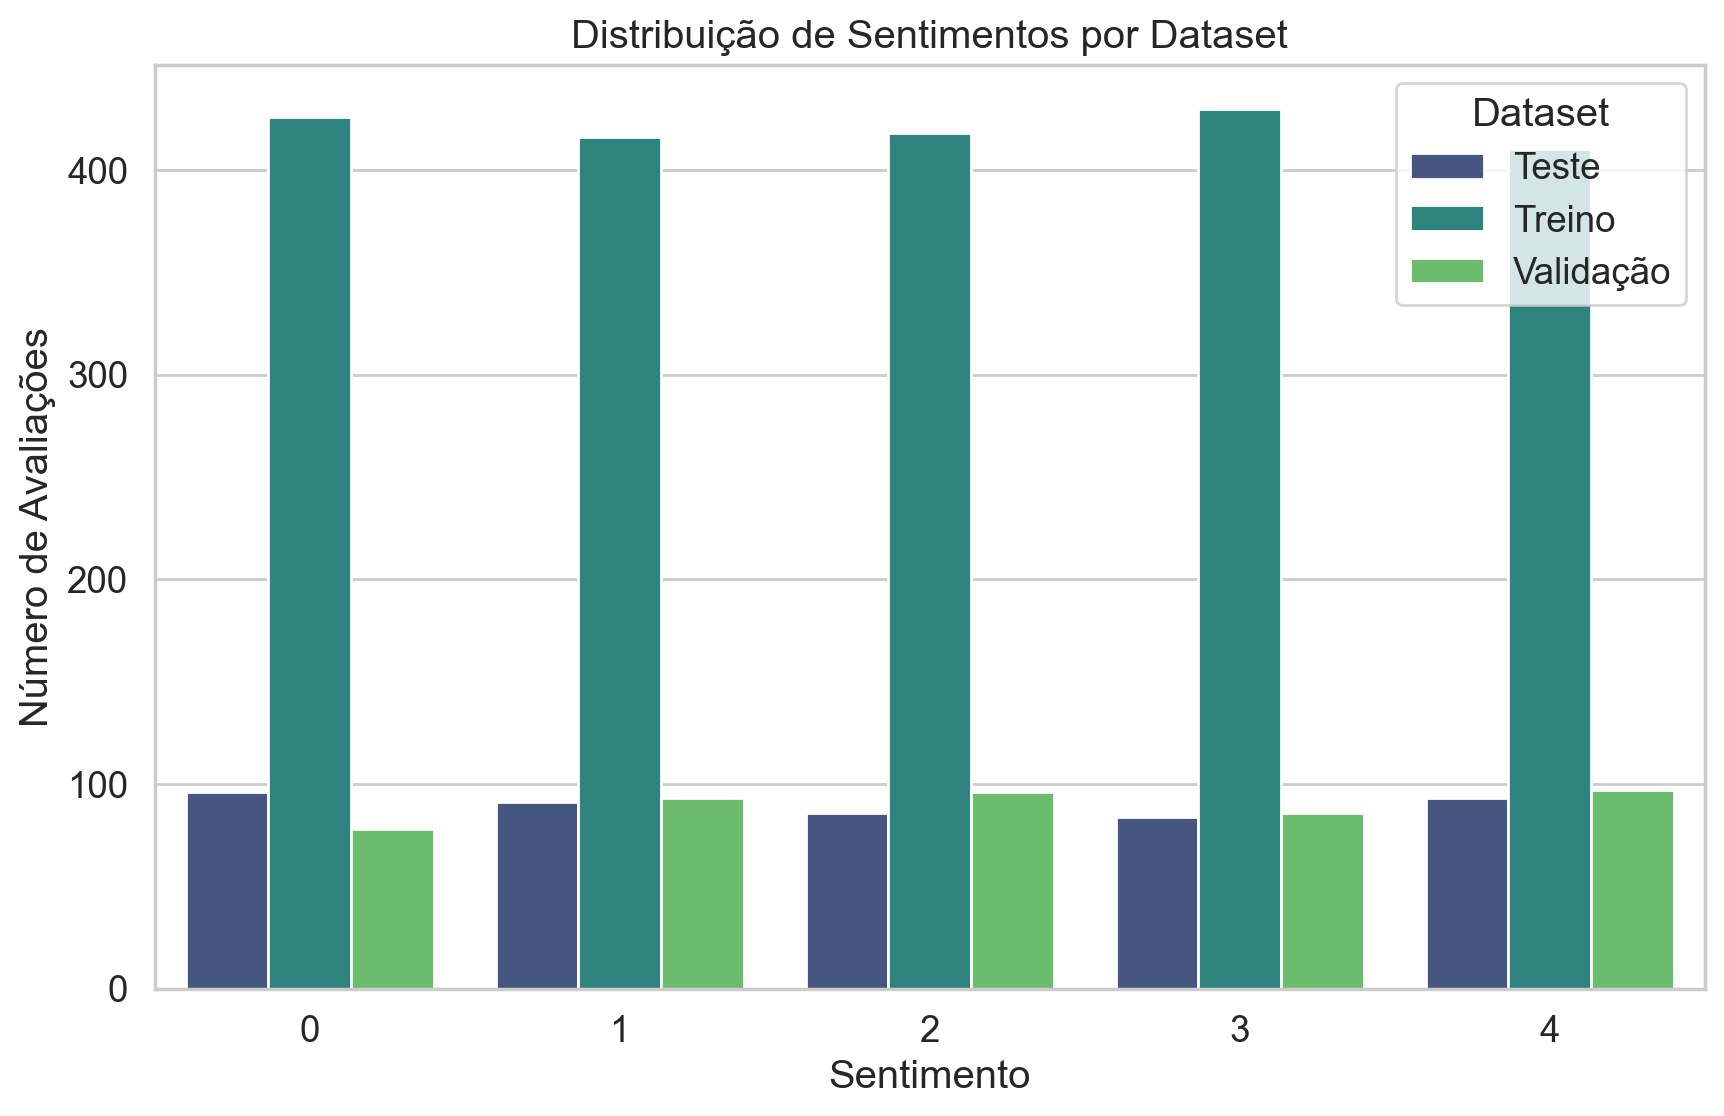

In [86]:
# Juntar os datasets com uma coluna indicando a origem
df_train["dataset"] = "Treino"
df_val["dataset"] = "Validação"
df_test["dataset"] = "Teste"

df_all = pd.concat([df_train, df_val, df_test], ignore_index=True)

# Contar as avaliações por dataset e sentimento
sentiment_counts = (
    df_all.groupby(["dataset", sentiment_column]).size().reset_index(name="count")
)

# Plotar com seaborn
plt.figure(figsize=(10, 6))
sns.barplot(
    data=sentiment_counts,
    x=sentiment_column,
    y="count",
    hue="dataset",
    palette="viridis",
)

plt.xlabel("Sentimento")
plt.ylabel("Número de Avaliações")
plt.title("Distribuição de Sentimentos por Dataset")
plt.legend(title="Dataset")
plt.show()


## Data Processing

Antes de alimentar textos para o modelo BERT, é necessário realizar algumas etapas de pré-processamento. O BERT requer um formato específico de entrada, e uma das etapas essenciais é a criação de vetores de 0s e 1s chamados attention mask, que indicam quais tokens devem ser considerados válidos, e a adição de três tokens especiais aos textos:

* [SEP] (102)- Marca o fim de uma frase
* [CLS] (101)- Deve ser colocado no inicio de cada frase para o BERT saber que trata-se de um problema de classificação.
* [PAD] (0)- Tokens de valor 0 que devem ser adicionados às sentenças para garantir que todas tenham o mesmo tamanho.

Esses tokens podem ser adicionados utilizando o método [encode_plus](https://huggingface.co/docs/transformers/main_classes/tokenizer#transformers.PreTrainedTokenizer.encode_plus) da Hugging Face. Esse método realiza várias operações essenciais, como:

* Tokenizar o texto: Converte as palavras em IDs de tokens que correspondem ao vocabulário do modelo BERT.
Adicionar tokens especiais: Insere automaticamente os tokens [CLS], [SEP] e [PAD] quando necessário.
* Realizar padding (preenchimento): Preenche as sentenças mais curtas com tokens [PAD] até atingir o comprimento máximo especificado.
* Gerar máscara de atenção (attention mask): Cria uma máscara que indica quais tokens são reais (com valor 1) e quais são de preenchimento (com valor 0), ajudando o modelo a focar nos tokens importantes.
* Controle de truncamento: Garante que textos mais longos sejam truncados para o comprimento máximo permitido.
* Retornar tensores: Converte os resultados para tensores PyTorch ou TensorFlow, prontos para uso em modelos de aprendizado de máquina.

1. **Tokens Especiais:**
* [CLS] (101): Deve ser colocado no início de cada frase para que o BERT saiba que trata-se de um problema de classificação.
* [SEP] (102): Marca o fim de uma frase ou sequência.
* [PAD] (0): Tokens de valor 0 que devem ser adicionados às sentenças para garantir que todas tenham o mesmo tamanho (padding).
[UNK] (100): Token utilizado para palavras desconhecidas, que não foram vistas durante o treinamento. Ex:
 * 101 -> [CLS]
 * 2146 -> "O"
 * 1004 -> "BERT"
 * 2003 -> "é"
 * 1037 -> "uma"
 * 4600 -> "ferramenta"
 * 2395 -> "poderosa"
 * 102 -> [SEP]

2. **Padding (Preenchimento):**
* O BERT espera que todas as entradas tenham o mesmo comprimento. Isso significa que você precisará preencher (pad) as sentenças mais curtas com tokens de preenchimento (como 0) até um comprimento fixo. Isso é necessário para processamento em lotes (batches) eficiente. Ex:
 * 101 -> [CLS]
 * 2146 -> "O"
 * 1004 -> "BERT"
 * 2003 -> "é"
 * 1037 -> "uma"
 * 4600 -> "ferramenta"
 * 2395 -> "poderosa"
 * 102 -> [SEP]
 * 0 -> [PAD]
 * 0 -> [PAD]
 * 0 -> [PAD]
 * 0 -> [PAD]

3. **Máscara de Atenção (Attention Mask):**
* A máscara de atenção é uma matriz que indica quais tokens são reais (com valor 1) e quais são de preenchimento (com valor 0). Isso ajuda o BERT a se concentrar nos tokens importantes e ignorar os preenchimentos. Ex:
 * 101 -> 1
 * 2146 -> 1
 * 1004 -> 1
 * 2003 -> 1
 * 1037 -> 1
 * 4600 -> 1
 * 2395 -> 1
 * 102 -> 1
 * 0 -> 0
 * 0 -> 0
 * 0 -> 0
 * 0 -> 0

#### Exemplo do processo de tokenização

In [87]:
sample_txt = "Santa Helena é uma cidade"

tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f" Sentence: {sample_txt}")
print(f"   Tokens: {tokens}")
print(f"Token IDs: {token_ids}")

 Sentence: Santa Helena é uma cidade
   Tokens: ['Santa', 'Helena', 'é', 'uma', 'cidade']
Token IDs: [1838, 9722, 253, 230, 651]


In [88]:
# [SEP] - Marcador para indicar o fim de uma sentença.
tokenizer.sep_token, tokenizer.sep_token_id

('[SEP]', 102)

In [89]:
# [CLS] - Token que deve ser adicionado no início de cada sentença.
tokenizer.cls_token, tokenizer.cls_token_id

('[CLS]', 101)

In [90]:
# [PAD] - Token de preenchimento utilizado para garantir que todas as sentenças tenham o mesmo tamanho (padding).
tokenizer.pad_token, tokenizer.pad_token_id

('[PAD]', 0)

In [91]:
# [UNK] - Token de palavras desconhecidas, usadas para palavras que não apareceram no conjunto de treinamento do modelo.
tokenizer.unk_token, tokenizer.unk_token_id

('[UNK]', 100)

Todo esse trabalho pode ser feito usando o método [encode_plus](https://huggingface.co/transformers/main_classes/tokenizer.html#transformers.PreTrainedTokenizer.encode_plus):

In [92]:
# Usa o método encode_plus() para preparar os dados para o modelo
encoding = tokenizer.encode_plus(
    sample_txt,  # Texto a ser tokenizado
    add_special_tokens=True,  # Adiciona os tokens especiais [CLS] no início e [SEP]
    max_length=9,  # Define o comprimento máximo da sequência "entrada" (160 tokens "palavras" neste caso)
    truncation=True,  # Trunca a sequência se ultrapassar o comprimento máximo
    pad_to_max_length=True,  # Realiza o padding, adicionando tokens de preenchimento [PAD] até o comprimento máximo
    return_token_type_ids=False,  # Não retorna os 'token_type_ids', pois não são necessários para analise de sentimentos
    return_attention_mask=True,  # Retorna a máscara de atenção, indicando quais tokens devem ser considerados (1 para tokens reais, 0 para padding)
    return_tensors="pt",  # Retorna os resultados em formato de tensor PyTorch
)

# O dicionário resultante contém 'input_ids' (sequência de tokens) e 'attention_mask' (máscara de atenção)
encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [93]:
encoding

{'input_ids': tensor([[ 101, 1838, 9722,  253,  230,  651,  102,    0,    0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 0, 0]])}

In [94]:
# Os IDs dos tokens agora são armazenados em um Tensor e preenchidos até um comprimento de 160 colunas
print(
    len(encoding["input_ids"][0])
)  # Exibe o comprimento da sequência de tokens (esperado 160, incluindo tokens especiais e padding)
# Exibe o tensor contendo os IDs dos tokens, incluindo o [CLS], [SEP] e tokens de preenchimento [PAD]
encoding["input_ids"]

# A máscara de atenção tem o mesmo comprimento:
print(len(encoding["attention_mask"][0]))
# Exibe a máscara de atenção (1 para tokens reais, 0 para tokens de padding)
encoding["attention_mask"]

9


tensor([[ 101, 1838, 9722,  253,  230,  651,  102,    0,    0]])

9


tensor([[1, 1, 1, 1, 1, 1, 1, 0, 0]])

In [95]:
# Converte os IDs dos tokens de volta para tokens
tokenizer.convert_ids_to_tokens(encoding["input_ids"][0])

['[CLS]', 'Santa', 'Helena', 'é', 'uma', 'cidade', '[SEP]', '[PAD]', '[PAD]']

##### Exemplo: Codificação do nosso texto de exemplo:

In [96]:
# Passa os tokens de entrada e a máscara de atenção para o modelo BERT
last_hidden_state, pooled_output = baseModel(
    input_ids=encoding[
        "input_ids"
    ],  # IDs dos tokens, gerados pelo tokenizer a partir do texto de entrada
    attention_mask=encoding["attention_mask"],  # Máscara de atenção
)

# last_hidden_state é a saída da última camada oculta do modelo BERT
# Ele contém as representações de cada token no contexto da frase inteira
# Forma: [batch_size, sequence_length, hidden_size]
# Ex: Para um modelo BERT Base, a dimensão será [batch_size, 768]

# pooled_output é a saída correspondente ao token [CLS] (usado para tarefas de classificação)
# É como um resumo da frase inteira, ou seja, é uma única representação para a frase
# Geralmente, usado para tarefas de classificação
# Forma: [batch_size, hidden_size]
# Ex: Para BERT Base, será [batch_size, 768]

In [97]:
# Forma: [batch_size, sequence_length, hidden_size]
# Last_hidden_state é a saída da última camada oculta do modelo BERT, contendo as representações de cada token no contexto da frase inteira
last_hidden_state.shape

torch.Size([1, 9, 768])

In [98]:
# Forma: [batch_size, hidden_size]
# Lembrando que pooled_output é a saída correspondente ao token [CLS], que é uma representação da frase inteira, usada para classificação
pooled_output.shape

torch.Size([1, 768])

O `last_hidden_state` é uma sequência de estados ocultos da última camada do modelo. A obtenção do `pooled_output` é feita aplicando o [BertPooler](https://github.com/huggingface/transformers/blob/edf0582c0be87b60f94f41c659ea779876efc7be/src/transformers/modeling_bert.py#L426) em `last_hidden_state`.

`pooled_output` é a saída correspondente ao token [CLS] (usado para tarefas de classificação)
Podemos pensar como um resumo da frase inteira, ou seja, é uma única representação para a frase.

In [99]:
# Obtém o tamanho do vetor de características ocultas (hidden_size) configurado no modelo BERT
# Para BERT Base, o valor será 768. Para BERT Large, será 1024.
baseModel.config.hidden_size

768

#### Escolhendo o comprimento da sequência

BERTimbau Base e BERTimbau Large: as entradas podem ter até 512 palavras (tokens)

Para escolher o comprimento máximo de sequência, vamos armazenar o número de tokens de cada review

In [100]:
token_lens = [
    len(tokenizer.encode(txt, truncation=True, max_length=512))
    for dataset in [df_train, df_val, df_test]
    for txt in dataset.content
]

Exibir a distribuição

<Axes: ylabel='Count'>

Text(0.5, 0, 'Contagem de Tokens')

Text(0, 0.5, 'Frequência')

Text(0.5, 1.0, 'Distribuição do Número de Tokens')

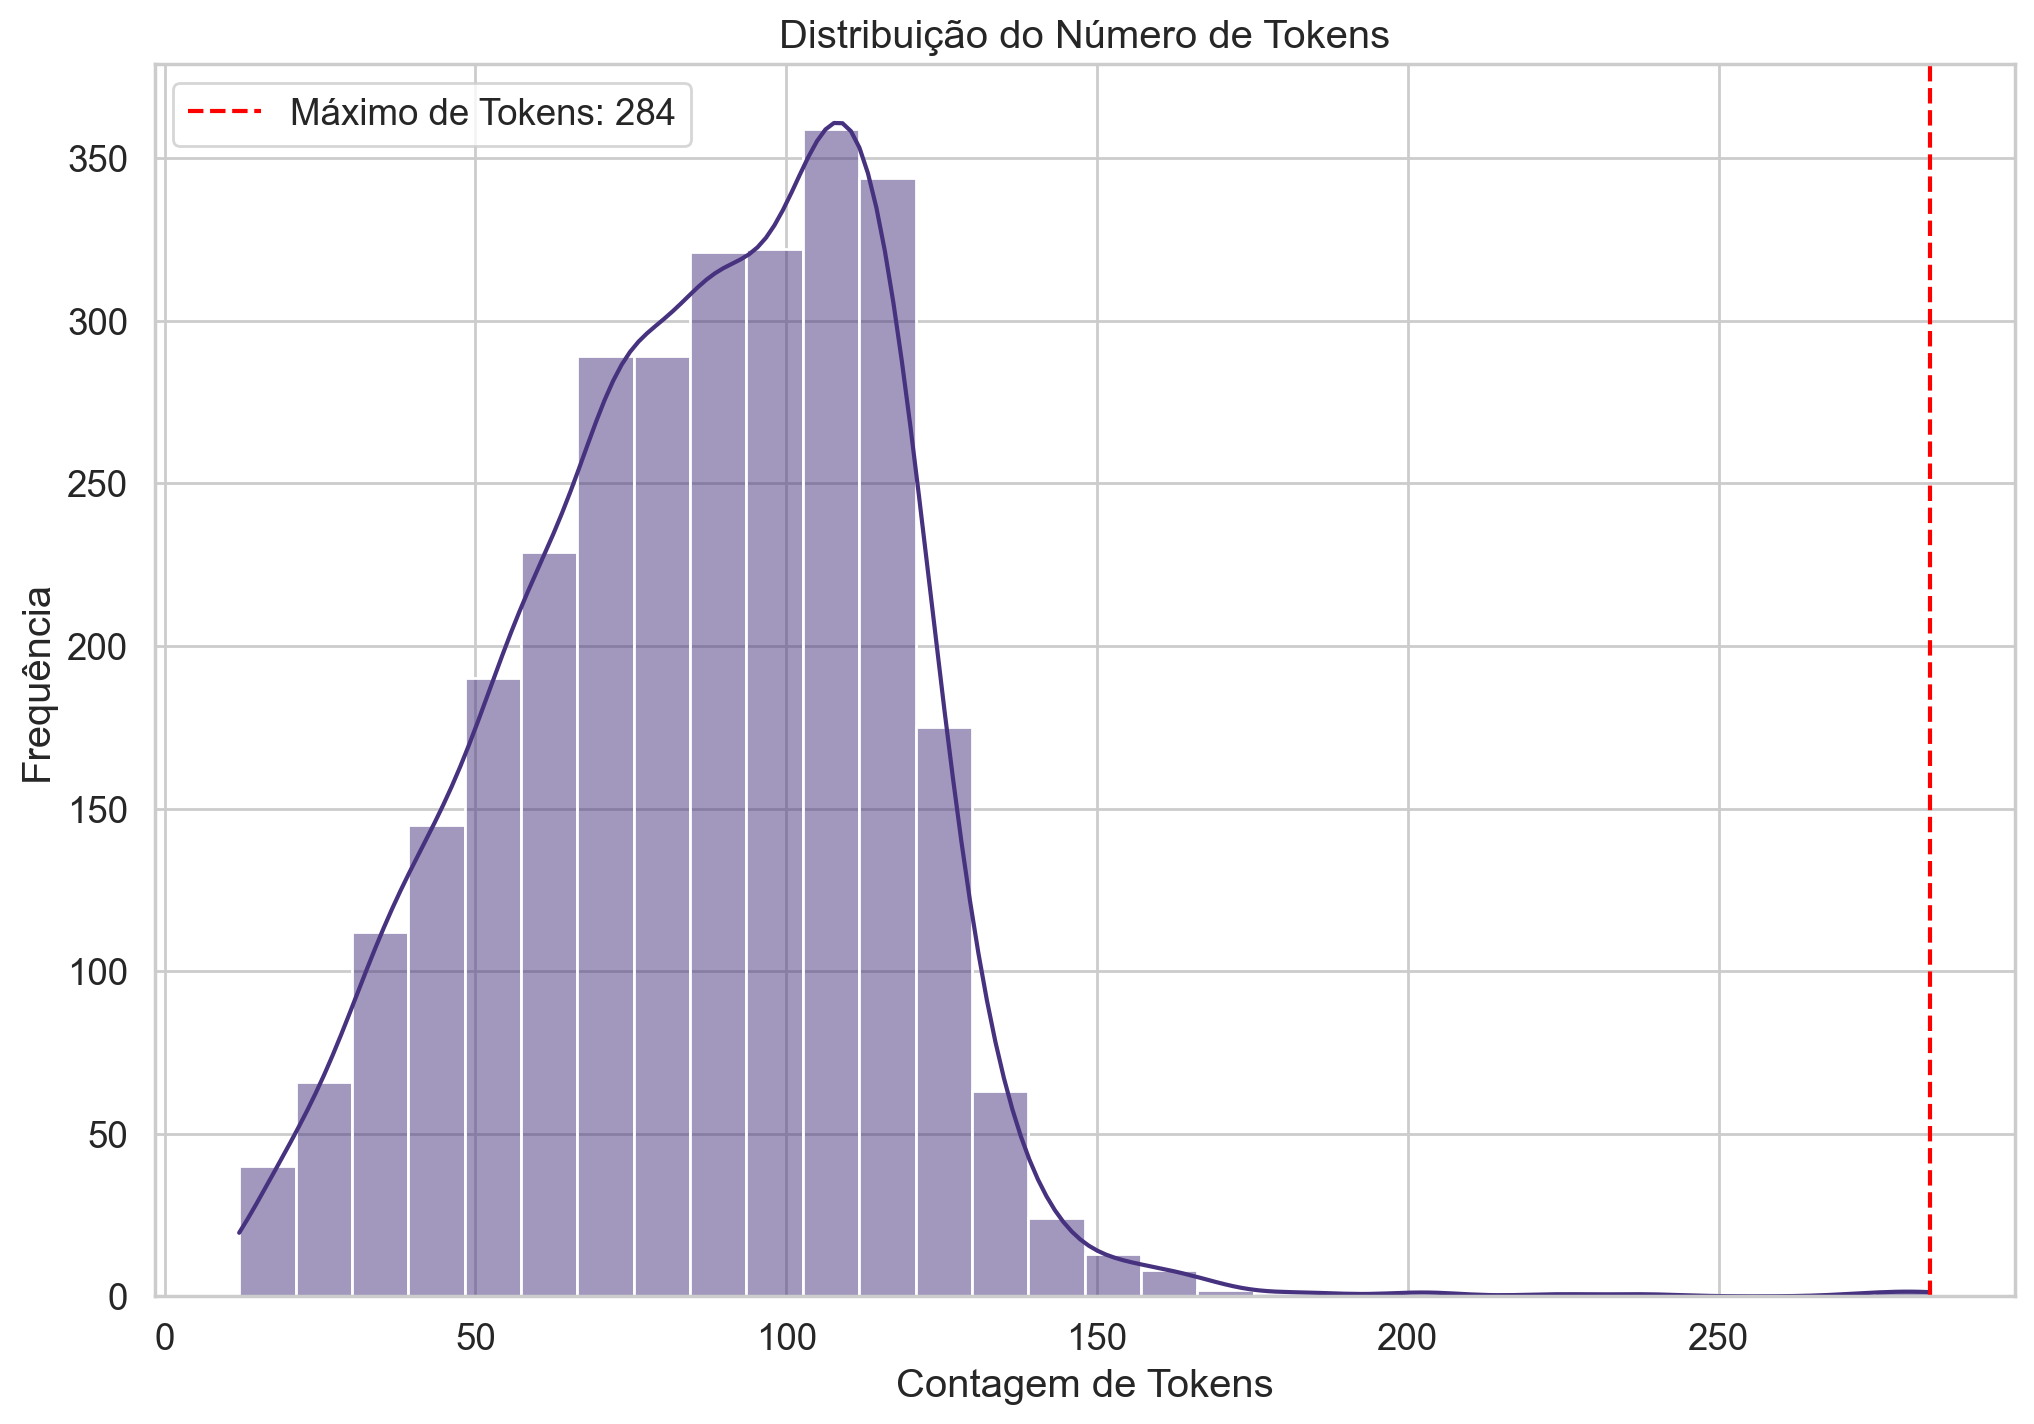

In [101]:
sns.histplot(token_lens, bins=30, kde=True)  # kde=True adiciona a curva de densidade

# Define os rótulos e o título
plt.xlabel("Contagem de Tokens")
plt.ylabel("Frequência")
plt.title("Distribuição do Número de Tokens")

# Encontra e exibe o número máximo de tokens no gráfico
MAX_LEN = max(token_lens)
plt.axvline(MAX_LEN, color="r", linestyle="--", label=f"Máximo de Tokens: {MAX_LEN}")

# Adiciona uma legenda para explicar a linha vermelha
plt.legend()

# Exibe o gráfico (opcional, dependendo do seu ambiente de execução)
plt.show()

In [102]:
MAX_LEN = 512 if MAX_LEN >= 512 else MAX_LEN

print(f"O comprimento máximo de tokens é: {MAX_LEN}")

O comprimento máximo de tokens é: 284


#### Criando o Dataset

In [103]:
# Estende a classe Dataset do PyTorch
class GPReviewDataset(Dataset):
    # Inicializa o dataset com os reviews, targets (sentimentos), tokenizador e o comprimento máximo da sequência
    def __init__(self, reviews, targets, tokenizer, max_len):
        self.reviews = reviews  # Armazena os textos das avaliações
        self.targets = targets  # Armazena os sentimentos das avaliações
        self.tokenizer = tokenizer  # Tokenizador BERT
        self.max_len = max_len  # Comprimento máximo da sequência

    # Método __len__ retorna o número de exemplos no dataset (Númeor de reviews)
    def __len__(self):
        return len(self.reviews)

    # Método __getitem__ recupera um item individual do dataset
    def __getitem__(self, item):
        review = str(self.reviews[item])  # Obtém o review atual e o converte em string
        target = self.targets[item]  # Obtém o rótulo correspondente ao review atual

        # Codifica o review em IDs de tokens e máscaras de atenção usando o tokenizador BERT
        encoding = self.tokenizer.encode_plus(
            review,
            add_special_tokens=True,  # Adiciona tokens especiais como [CLS] e [SEP]
            max_length=self.max_len,  # Define o comprimento máximo para truncamento/preenchimento
            truncation=True,  # Trunca a sequência se ultrapassar o comprimento máximo
            return_token_type_ids=False,  # Não retorna os IDs de tipo de token, pois não é necessário
            padding="max_length",  # Preenche as sequências até o comprimento máximo
            return_attention_mask=True,  # Retorna a máscara de atenção que indica os tokens válidos
            return_tensors="pt",  # Retorna os tensores prontos para PyTorch
        )

        # Retorna um dicionário com o texto do review, os IDs dos tokens, a máscara de atenção e o rótulo
        return {
            "review_text": review,  # O review original em texto
            "input_ids": encoding[
                "input_ids"
            ].flatten(),  # IDs dos tokens achatados em uma dimensão
            "attention_mask": encoding[
                "attention_mask"
            ].flatten(),  # Máscara de atenção achatada
            "targets": torch.tensor(
                target, dtype=torch.long
            ),  # Rótulo convertido para tensor PyTorch de tipo long
        }

Criar alguns carregadores de dados. Aqui está uma função auxiliar para fazer isso:

In [104]:
def create_data_loader(df, tokenizer, max_len, batch_size, shuffle: bool):
    # Cria um dataset GPReviewDataset a partir dos dados de entrada
    ds = GPReviewDataset(
        reviews=df.content.to_numpy(),  # Converte a coluna dos reviews (content) para um array numpy
        targets=df[
            sentiment_column
        ].to_numpy(),  # Converte a coluna de sentimentos para um array numpy
        tokenizer=tokenizer,  # Tokenizador do BERT para processar os reviews
        max_len=max_len,  # Comprimento máximo para o padding/truncamento
    )

    # Retorna um DataLoader para o dataset, que divide os dados em lotes
    return DataLoader(
        dataset=ds,  # O dataset criado
        batch_size=batch_size,  # Tamanho do lote
        num_workers=0,  # Evita o multiprocessamento, usando um único processo para carregar os dados
        shuffle=shuffle,  # Embaralha ou não dados a cada época para melhorar a generalização do modelo
    )

Criando DataLoaders para os conjuntos de dados de treinamento, validação e teste

In [105]:
# Cada DataLoader vai conter os dados em lotes, facilitando o treinamento do modelo
# Dados de treinamento são embaralhados (shuffle = True)
train_data_loader = create_data_loader(
    df_train, tokenizer, MAX_LEN, BATCH_SIZE, shuffle=True
)
val_data_loader = create_data_loader(
    df_val, tokenizer, MAX_LEN, BATCH_SIZE, shuffle=False
)
test_data_loader = create_data_loader(
    df_test, tokenizer, MAX_LEN, BATCH_SIZE, shuffle=False
)

In [106]:
print('Numero de lotes "batches" de treinamento:', len(train_data_loader))
print('Tamanho dos lotes "batches" de treinamento:', train_data_loader.batch_size)

print('Numero de lotes "batches" de validação:', len(val_data_loader))
print('Tamanho dos lotes "batches" de validação:', val_data_loader.batch_size)

print('Numero de lotes "batches" de teste:', len(test_data_loader))
print('Tamanho dos lotes "batches" de teste:', test_data_loader.batch_size)

Numero de lotes "batches" de treinamento: 525
Tamanho dos lotes "batches" de treinamento: 4
Numero de lotes "batches" de validação: 113
Tamanho dos lotes "batches" de validação: 4
Numero de lotes "batches" de teste: 113
Tamanho dos lotes "batches" de teste: 4


In [107]:
print(f"DataLoader de treino: {len(train_data_loader.dataset.reviews)}")
print(f"DataLoader de validação: {len(val_data_loader.dataset.reviews)}")
print(f"DataLoader de teste: {len(test_data_loader.dataset.reviews)}")

DataLoader de treino: 2100
DataLoader de validação: 450
DataLoader de teste: 450


## Criando o Modelo

In [108]:
# Definindo o Classificador de Sentimento (BERT + Dropout + Camada Final) para Classificação.
class SentimentClassifier(nn.Module):
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()

        # Inicializa o modelo BERT pré-treinado.
        # O BERT será responsável por gerar as representações contextuais dos textos de entrada.
        # O `return_dict=False` significa que o retorno será uma tupla e não um dicionário.
        self.bert = AutoModel.from_pretrained(PRE_TRAINED_MODEL_NAME, return_dict=False)

        # Camada de Dropout para regularização durante o treinamento.
        # Dropout é uma técnica que desativa aleatoriamente algumas conexões entre neurônios,
        # ajudando a evitar overfitting.
        self.drop = nn.Dropout(p=DROPOUT)

        # Camada final totalmente conectada (linear), que mapeia o vetor de saída do BERT para a quantidade de classes de saída.
        # O número de features de entrada (in_features) é o tamanho da saída do BERT (geralmente 768).
        # O número de classes (out_features) é especificado pelo parâmetro `n_classes`, que no caso é 5 para sentimentos.
        self.out = nn.Linear(
            in_features=self.bert.config.hidden_size, out_features=n_classes
        )

    def forward(self, input_ids, attention_mask):
        # O método forward define o que acontece quando o modelo recebe dados de entrada.
        # O modelo BERT gera uma tupla com duas saídas: sequence_output e pooled_output.
        # A variável 'pooled_output' é a saída do token [CLS], que será usada para classificação.
        # `input_ids`: ids dos tokens que representam o texto.
        # `attention_mask`: mascara que indica quais tokens devem ser atendidos (ignora padding).

        # `pooled_output` é a representação do token [CLS], que é utilizado para tarefas de classificação.
        _, pooled_output = self.bert(
            input_ids=input_ids,  # IDs dos tokens de entrada
            attention_mask=attention_mask,  # Máscara de atenção para ignorar tokens de padding
        )

        # Aplica o Dropout sobre o pooled_output para regularização.
        # Durante o treinamento, algumas conexões são "desligadas" para evitar overfitting.
        output = self.drop(pooled_output)

        # A saída do Dropout é passada pela camada totalmente conectada (linear) para gerar as previsões de classe.
        # Aqui, `self.out(output)` retorna os logits para cada classe (por exemplo, positivo, neutro, negativo).
        return self.out(output)


Usamos uma camada dropout para alguma regularização e uma camada totalmente conectada para nossa saída. Observe que estamos retornando a saída bruta da última camada, pois isso é necessário para que a função cross-entropy loss function no PyTorch funcione.

In [109]:
# Instanciar o modelo de classificação de sentimentosmovê-lo para a GPU:
# O número de classes é 5 (extremamente negativo, negativo, neutro, positivo, extremamente positivo).
model = SentimentClassifier(len(class_names))
model = model.to(device)

Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### Exemplo

In [110]:
# EXEMPLO
# Obtendo o primeiro lote de dados do train_data_loader
data = next(iter(train_data_loader))
# Exibindo as dimensões dos tensores de um lote de dados

print("Saida [batch_size, max_len]")

print(
    "input_ids shape: ", data["input_ids"].shape
)  # Formato esperado: [batch_size, max_len] para os IDs dos tokens dos reviews
print(
    "attention_mask shape: ", data["attention_mask"].shape
)  # Formato esperado: [batch_size, max_len] para a máscara de atenção
print(
    "targets shape: ", data["targets"].shape
)  # Formato esperado: [batch_size] para os rótulos (sentimentos)

# Saida [batch_size, max_len]
# 'batch_size' refere-se ao número de amostras no lote.
# 'max_len'  refere-se ao número máximo de tokens por amostra (É o valor de MAX_LEN que foi configurado anteriormente).

Saida [batch_size, max_len]
input_ids shape:  torch.Size([4, 284])
attention_mask shape:  torch.Size([4, 284])
targets shape:  torch.Size([4])


In [111]:
# EXEMPLO
# Move os 'input_ids' e 'attention_mask' para o dispositivo correto (GPU ou CPU)
# 'input_ids' contém os IDs dos tokens do texto de entrada, já processados pelo tokenizador do BERT
# 'attention_mask' contém uma máscara que indica quais tokens são válidos (1) e quais são padding (0)
input_ids = data["input_ids"].to(device)
attention_mask = data["attention_mask"].to(device)

## model(input_ids, attention_mask):
# Esta parte passa os dados de entrada para o modelo (input_ids e attention_mask)
# O modelo retorna uma saída, que é uma previsão bruta (logits) para cada classe.
outputs = model(input_ids, attention_mask)

# Aplica a função softmax nos logits para converter os valores brutos em probabilidades de classe
# A função `softmax` garante que a soma das probabilidades seja 1 para cada exemplo no batch
# `dim=1` indica que a operação softmax deve ser aplicada ao longo da segunda dimensão (as colunas), ou seja, sobre as classes
# Isso faz com que as previsões se tornem probabilidades, onde a classe com a maior probabilidade será a prevista
predictions = F.softmax(outputs, dim=1)

print("Outputs - Previsão bruta (logits) para cada classe: ", outputs)
print("Predictions - Probabilidades de classe: ", predictions)

Outputs - Previsão bruta (logits) para cada classe:  tensor([[-0.0213,  0.2615, -0.2433, -0.2214,  0.7504],
        [ 0.1880,  0.0560, -0.3781, -0.0728,  0.2225],
        [ 0.0660,  0.1357, -0.5453, -0.0548,  0.4466],
        [ 0.0116,  0.1151, -0.1885, -0.3118,  0.0169]],
       grad_fn=<AddmmBackward0>)
Predictions - Probabilidades de classe:  tensor([[0.1637, 0.2172, 0.1311, 0.1340, 0.3541],
        [0.2353, 0.2062, 0.1336, 0.1813, 0.2436],
        [0.2014, 0.2160, 0.1093, 0.1785, 0.2947],
        [0.2147, 0.2382, 0.1758, 0.1554, 0.2159]], grad_fn=<SoftmaxBackward0>)


## Treino

Procedimento de Treinamento e Otimização:

- Para replicar a metodologia de treinamento do artigo original do BERT, o processo de ajuste fino será conduzido utilizando o otimizador AdamW, fornecido pela biblioteca Hugging Face. Este otimizador é uma variante do Adam que implementa a correção do weight decay (decaimento de peso), alinhando-se com a abordagem descrita pelos autores para evitar o overfitting.

- Adicionalmente, será empregado um agendador linear de taxa de aprendizado (get_linear_schedule_with_warmup), configurado sem etapas de warm-up. Este agendador ajusta a taxa de aprendizado de forma gradual ao longo das épocas, contribuindo para uma convergência mais estável e eficiente do modelo.

In [112]:
# --- Tratamento de Classes Desbalanceadas ---

# Importa a função específica para calcular os pesos das classes da biblioteca Scikit-learn.
from sklearn.utils.class_weight import compute_class_weight

# 1. Calcula os pesos para cada classe.
# Esta função ajuda a criar pesos que serão usados para penalizar mais os erros
# do modelo em classes com poucos exemplos durante o treinamento.
class_weights = compute_class_weight(
    # Parâmetro 'class_weight':
    # Define a estratégia para calcular os pesos.
    # 'balanced' -> Calcula os pesos de forma inversamente proporcional à frequência da classe.
    #               Ou seja, classes com menos amostras (raras) recebem um peso maior,
    #               e classes com muitas amostras (comuns) recebem um peso menor.
    class_weight="balanced",
    # Parâmetro 'classes':
    # Um array com todas as classes únicas presentes no seu dataset.
    # Ex: [0, 1, 2] ou ['negativo', 'neutro', 'positivo'].
    # np.unique() garante que pegamos cada classe apenas uma vez.
    classes=np.unique(df_train[sentiment_column]),
    # Parâmetro 'y':
    # Um array contendo os rótulos (targets) de todos os seus dados de treino.
    # A função usa este array para contar a frequência de cada classe
    # e aplicar a estratégia 'balanced'.
    y=df_train[sentiment_column].to_numpy(),
)

print(class_weights)

# 2. Converte os pesos (que estão em um array numpy) para um tensor do PyTorch.
# A função de perda do PyTorch (nn.CrossEntropyLoss) espera receber os pesos neste formato.
# -> 'dtype=torch.float': Garante que os pesos sejam números de ponto flutuante (ex: 32-bit float).
# -> '.to(device)': Move o tensor de pesos para o dispositivo de processamento correto (CPU ou GPU),
weights = torch.tensor(class_weights, dtype=torch.float).to(device)

[0.98591549 1.00961538 1.00478469 0.97674419 1.02439024]


In [113]:
# Função de perda (loss function)
# - CrossEntropyLoss é usada em tarefas de classificação multiclasse.
# - Ele compara a previsão do modelo (outputs) com a resposta correta (targets).
# - Calcula um único número (loss), que significa o quão "errada" foi a previsão.
# - Quanto maior a perda (loss), pior foi o desempenho do modelo no batch.
# - OBS - Caso o dataset seja desbalanceado, pode-se incluir pesos para cada classe.

if CLASS_WEIGHTS:
    # Erros em classes raras agora terão uma penalidade maior, forçando o modelo a aprendê-las.
    print("Usando pesos para classes desbalanceadas 👍")
    loss_fn = nn.CrossEntropyLoss(weight=weights).to(device)
else:
    print("Não usando pesos para as classes. 👎")
    loss_fn = nn.CrossEntropyLoss().to(device)

Usando pesos para classes desbalanceadas 👍


In [114]:
# Otimizador AdamW
# - AdamW é o otimizador recomendado para Transformers.
# - Ele ajusta os pesos da rede neural durante o treinamento.
# - Com base no valor da perda calculado pela (loss_fn), ele determina como ajustar cada um dos milhões de pesos
# dentro do modelo, para que, da próxima vez, a perda seja menor. Ele implementa o algoritmo que efetivamente faz
# o modelo aprender.
# - O parâmetro weight_decay=0.01 ajuda a reduzir overfitting penalizando pesos muito grandes.
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=0.01)

# optimizer = AdamW(
#     model.parameters(),
#     lr=LEARNING_RATE,
# )

# Número total de passos (batches) durante todo o treinamento
# Fórmula: total de lotes por época * número de épocas
total_steps = len(train_data_loader) * EPOCHS

# Passos de "aquecimento" (warmup) da taxa de aprendizado
# Durante ~10% dos primeiros passos, a learning rate cresce gradualmente
# Isso evita instabilidade no início do treino.
# num_warmup_steps = 0
num_warmup_steps = int(0.1 * total_steps)

# Scheduler (agendador) para a taxa de aprendizado
# - Ele controla um hiperparametro muito importante: a taxa de aprendizado (learning rate).
# Em vez de manter essa taxa fixa, o scheduler a ajusta dinamicamente durante o treinamento
# (aumentando no inicio e depois diminuindo), o que ajuda o modelo a convergir de forma mais rápida e estável.
# - Começa aumentando gradualmente a learning rate (warmup)
# - Depois decai linearmente até o final do treino
# Esse ajuste dinâmico ajuda o modelo a convergir melhor.
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=num_warmup_steps,  # número de passos para "aquecer"
    num_training_steps=total_steps,  # número total de passos de treino
)

Função auxiliar para treinar nosso modelo para uma época:

In [115]:
from tqdm import tqdm  # Importa a biblioteca para criar barras de progresso visuais


def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    """
    Executa uma época de treinamento do modelo.

    Args:
        model: O modelo a ser treinado.
        data_loader: O DataLoader com os dados de treinamento.
        loss_fn: A função de perda.
        optimizer: O otimizador.
        device: O dispositivo (GPU/CPU) para treinamento.
        scheduler: O agendador de taxa de aprendizado.
        n_examples: O número total de exemplos de treinamento.

    Returns:
        Uma tupla contendo a acurácia e a perda média da época.
    """
    # Colocamos nosso modelo em "modo estudo".
    # Isso ativa camadas como o Dropout, que ajudam a evitar que o modelo "decore" as respostas.
    # É como dizer ao aluno: "Preste atenção, é hora de aprender, não de fazer prova."
    model = model.train()

    # Criamos "cadernos" para anotar o desempenho do modelo durante a aula.
    # 'losses' vai guardar a "nota" de erro de cada exercício.
    # 'correct_predictions' vai contar quantas respostas o aluno acertou.
    losses = []
    correct_predictions = 0

    total_steps = len(data_loader)  # Total de batches (Lotes de dados) no DataLoader
    print(f"Total de passos - batches: {total_steps}")
    # Usando tqdm para a barra de progresso com uma descrição clara
    progress_bar = tqdm(
        enumerate(data_loader, 1),
        total=total_steps,
        desc="Iniciando Treinamento",
        ncols=100,
    )

    # Para cada batch (lote de dados) de dados no DataLoader
    for batch in data_loader:
        # Move os 'input_ids' e 'attention_mask' para o dispositivo correto (GPU ou CPU)
        input_ids = batch["input_ids"].to(device)  # IDs dos tokens de entrada
        attention_mask = batch["attention_mask"].to(
            device
        )  # Máscara de atenção para ignorar tokens de padding
        targets = batch["targets"].to(device)  # Rótulos (sentimentos)

        # Passa os dados de entrada para o modelo (input_ids e attention_mask).
        # O modelo processa cada entrada. Se um batch tiver 16 entradas, processará 16 entradas.
        # outputs é a lista de saídas do modelo, que contém os logits para cada classe.
        # os logits são os valores brutos de previsão para cada classe. Ainda não são probabilidades.
        outputs = model(
            input_ids=input_ids,  # IDs dos tokens de entrada
            attention_mask=attention_mask,  # Máscara de atenção para ignorar tokens de padding
        )

        # Exemplo de saída (logits) para um batch com 2 exemplos e 5 classes:
        # tensor([
        #   [-0.0792,  0.1209,  0.0140,  0.1531,  0.1964],
        #   [-0.1822, -0.0655, -0.0424,  0.0147,  0.2308]
        # ])
        # Cada linha representa um exemplo no batch e cada coluna, um logit (pontuação) para uma classe.

        # Calcula a perda para o lote atual
        # Exemplo: se targets = tensor([4, 3]) e preds tensor([4, 4]),
        # a loss pode ser algo como: tensor(0.47)
        loss = loss_fn(outputs, targets)

        # Backpropagation
        # Aqui, descobrimos EXATAMENTE onde o modelo errou em seu raciocínio.
        # O PyTorch calcula um "gradiente" para cada peso do modelo, um mapa que aponta
        # a direção e a intensidade da correção necessária para cada "neurônio".
        loss.backward()

        # Aplica clipping nos gradientes para evitar explosões (exploding gradients)
        # Antes de corrigir, verificamos se o "mapa da correção" não é exagerado.
        # Se a correção for grande demais (explosão de gradiente), ela pode desestabilizar o modelo.
        # Essa linha garante que a correção seja firme, mas não destrutiva, no máximo 1.0
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        # "A Correção de Fato"
        # O otimizador pega o mapa da correção e ajusta os pesos (o conhecimento) do modelo.
        # É neste exato momento que o aprendizado acontece!
        # Atualiza os pesos do modelo com base nos gradientes calculados.
        # Ele dá um pequeno passo na direção que deve diminuir a perda.
        optimizer.step()

        # "Virando a Página" (Zerando os Gradientes):
        # Após a correção, limpamos o "mapa" (os gradientes).
        # Se não fizéssemos isso, a correção do próximo batch seria somada com a do anterior,
        # criando uma bagunça e impedindo o aprendizado correto.
        optimizer.zero_grad()

        # "Ajustando a Estratégia de Ensino" (Passo do Scheduler):
        # O scheduler ajusta a "intensidade" da correção (taxa de aprendizado) para o próximo batch.
        # Atualiza a taxa de aprendizado usando o scheduler, seguindo seu plano de aquecimento e decaimento.
        scheduler.step()

        # --- Anotando o Desempenho (Métricas - não afetam o treinamento) ---

        # Obtém as classes previstas com maior valor de logit para cada exemplo
        # Exemplo de saída: tensor([4, 4])  -> significa que o modelo previu a classe 4 para ambos
        _, preds = torch.max(outputs, dim=1)

        # Soma o número de acertos: compara a previsão com o rótulo real
        # Exemplo: preds = tensor([4, 4]), targets = tensor([4, 3]) → 1 acerto
        correct_predictions += torch.sum(preds == targets)

        # Adiciona a perda atual à lista de perdas
        losses.append(loss.item())

        # Atualiza a barra de progresso com a perda média do lote
        progress_bar.set_postfix({"loss": np.mean(losses)})
        progress_bar.update()

    # Após todos os batches, calcula a acurácia e a média da perda
    accuracy = correct_predictions.double() / n_examples
    mean_loss = np.mean(losses)

    return accuracy, mean_loss

O scheduler (agendador) é chamado sempre que um batch (lote) é alimentado no modelo. Evitamos a explosão de gradientes cortando os gradientes do modelo usando [clip_grad_norm_](https://pytorch.org/docs/stable/nn.html#clip-grad-norm).

Vamos escrever outro que nos ajude a avaliar o modelo em um determinado carregador de dados:

In [116]:
def eval_epoch(model, data_loader, loss_fn, device, n_examples):
    """
    Executa uma época de avaliação do modelo.

    Args:
        model: O modelo a ser avaliado.
        data_loader: O DataLoader com os dados de validação ou teste.
        loss_fn: A função de perda.
        device: O dispositivo (GPU/CPU) para avaliação.
        n_examples: O número total de exemplos de avaliação.

    Returns:
        Uma tupla contendo a acurácia e a perda média da época de avaliação.
    """
    model = model.eval()

    # Lista para armazenar as perdas e uma variável para contar as previsões corretas
    losses = []
    correct_predictions = 0

    # Desativa o cálculo de gradientes para a avaliação, economizando memória
    # e tempo de processamento.
    with torch.no_grad():
        # Para cada batch (lote de dados) de dados no DataLoader
        for d in data_loader:
            # Move os 'input_ids' e 'attention_mask' para o dispositivo correto (GPU ou CPU)
            input_ids = d["input_ids"].to(device)  # IDs dos tokens de entrada
            attention_mask = d["attention_mask"].to(
                device
            )  # Máscara de atenção para ignorar tokens de padding
            targets = d["targets"].to(device)  # Rótulos (sentimentos)

            # Passa os dados de entrada para o modelo (input_ids e attention_mask)
            # para obter as previsões
            # O modelo retorna uma saída, que é uma previsão bruta (logits) para cada classe.
            outputs = model(
                input_ids=input_ids,  # IDs dos tokens de entrada
                attention_mask=attention_mask,  # Máscara de atenção para ignorar tokens de padding
            )

            # Obtém as classes previstas com maior valor de logit (probabilidade bruta)
            _, preds = torch.max(outputs, dim=1)

            # Calcula a perda para o lote atual e a adiciona à lista
            loss = loss_fn(outputs, targets)
            losses.append(loss.item())

            # Soma o número de previsões corretas
            correct_predictions += torch.sum(preds == targets)

    # Calcula a acurácia (número de previsões corretas dividido pelo total de exemplos)
    accuracy = correct_predictions.double() / n_examples
    mean_loss = np.mean(losses)

    # Retorna a acurácia e a perda média
    return accuracy, mean_loss

Usando esses dois, podemos escrever nosso ciclo de treinamento. Também armazenaremos o histórico de treinamento.

Observe que estamos armazenando o estado do melhor modelo, indicado pelo maior validation accuracy (precisão de validação).

In [117]:
%%time

# Dicionário para armazenar o histórico do treinamento (acurácia e perda)
history = defaultdict(list)
# Variável para armazenar a melhor acurácia de validação encontrada até o momento
best_accuracy = 0

# Loop principal que executa para cada época
for epoch in range(EPOCHS):
    print(f"Época {epoch + 1}/{EPOCHS}")
    print("-" * 10)

    # ====================
    # FASE DE TREINAMENTO
    # ====================
    # Chama a função para treinar o modelo por uma época e obtém a acurácia e a perda de treino

    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(df_train),  # Passa o número total de exemplos de treinamento
    )

    print(f"Perda de Treino: {train_loss:.4f} | Acurácia de Treino: {train_acc:.4f}")

    # ====================
    # FASE DE VALIDAÇÃO
    # ====================
    # Chama a função para avaliar o modelo com os dados de validação
    val_acc, val_loss = eval_epoch(
        model,
        val_data_loader,
        loss_fn,
        device,
        len(df_val),  # Passa o número total de exemplos de validação
    )

    print(f"Perda de Validação: {val_loss:.4f} | Acurácia de Validação: {val_acc:.4f}")
    print("\n")

    # Armazena a acurácia e a perda da época no histórico
    history["train_acc"].append(
        train_acc
    )  # Adiciona a precisão de treinamento ao histórico
    history["train_loss"].append(
        train_loss
    )  # Adiciona a perda de treinamento ao histórico
    history["val_acc"].append(val_acc)  # Adiciona a precisão de validação ao histórico
    history["val_loss"].append(val_loss)  # Adiciona a perda de validação ao histórico

    # Salva o modelo com a melhor acurácia de validação
    # Esta é uma boa prática para evitar o overfitting e garantir
    # que o melhor modelo seja utilizado.
    if val_acc > best_accuracy:
        torch.save(model.state_dict(), "best_model_state.bin")
        best_accuracy = val_acc

Época 1/10
----------
Total de passos - batches: 525


Iniciando Treinamento:   2%|▋                           | 12/525 [00:50<35:57,  4.21s/it, loss=1.64]

CPU times: total: 5min 6s
Wall time: 51.8 s


KeyboardInterrupt: 

Visualização do Histórico de Treinamento

In [ ]:
# ==============================================================================
# VISUALIZAÇÃO DO HISTÓRICO DE TREINAMENTO
# ==============================================================================

# ------------------------------------------------------------------------------
# GRÁFICO 1: ACURÁCIA
# ------------------------------------------------------------------------------

train_acc = [x.cpu().item() if hasattr(x, "cpu") else x for x in history["train_acc"]]
val_acc = [x.cpu().item() if hasattr(x, "cpu") else x for x in history["val_acc"]]

# Cria um gráfico para visualizar a acurácia de treinamento e validação ao longo das épocas
plt.plot(train_acc, label="acurácia de treino")
plt.plot(val_acc, label="acurácia de validação")
plt.title("Acurácia de Treino vs. Validação")
plt.ylabel("Acurácia")
plt.xlabel("Épocas")
plt.legend()
plt.ylim([0, 1])
plt.show()

# ------------------------------------------------------------------------------
# GRÁFICO 2: PERDA (LOSS)
# ------------------------------------------------------------------------------

# Supondo que seu dicionário 'history' contenha 'train_loss' e 'val_loss'
train_loss = [x.cpu().item() if hasattr(x, "cpu") else x for x in history["train_loss"]]
val_loss = [x.cpu().item() if hasattr(x, "cpu") else x for x in history["val_loss"]]

# Cria um gráfico para visualizar a acurácia de treinamento e validação ao longo das épocas
plt.plot(train_loss, label="perda de treino")
plt.plot(val_loss, label="perda de validação")
plt.title("Perda de Treino vs. Validação")
plt.ylabel("Perda")
plt.xlabel("Épocas")
plt.legend()
plt.show()

## AVALIAÇÃO FINAL DADOS DE TESTE

#### Obter um modelo já treinado da internet

In [ ]:
# !gdown 16Xq3bNEx7Owf7kOMjfgQu-BkWsX7hEpV -O best_model_state.bin

# model = SentimentClassifier(len(class_names))
# model.load_state_dict(torch.load('best_model_state.bin'))
# model = model.to(device)

#### Carregar o modelo salvo localmente

In [ ]:
# ==============================================================================
# AVALIAÇÃO FINAL DO MELHOR MODELO
# ==============================================================================

# Definindo o caminho para o modelo salvo
model_path = os.path.join(os.getcwd(), "best_model_state.bin")

# Carregar o modelo
model = SentimentClassifier(
    len(class_names)
)  # Inicialize o modelo com a mesma arquitetura
model.load_state_dict(torch.load(model_path))  # Carregar o estado do modelo salvo
model = model.to(device)  # Enviar o modelo para o dispositivo (GPU ou CPU)


#### Avaliação

In [ ]:
# Vamos começar calculando a precisão dos dados de teste:

test_acc, _ = eval_epoch(model, test_data_loader, loss_fn, device, len(df_test))

test_acc.item()

Função para fazer previsões em um conjunto de dados.


Semelhante à função de avaliação, exceto que armazenamos o texto das revisões e as probabilidades previstas (aplicando o softmax nos resultados do modelo)

In [ ]:
def get_predictions(model, data_loader):
    # Define o modelo no modo de avaliação, desativando camadas como dropout e batchnorm
    model = model.eval()

    # Listas para armazenar os resultados
    review_texts = []  # Textos dos reviews
    predictions = []  # Classes previstas pelo modelo
    prediction_probs = []  # Probabilidades associadas às previsões
    real_values = []  # Valores reais (rótulos verdadeiros

    # Desativa o cálculo do gradiente, economizando memória e acelerando o processo
    with torch.no_grad():
        # Para cada batch (lote de dados) de dados no DataLoader
        for batch in data_loader:
            texts = batch["review_text"]  # Obtém os textos dos reviews

            # Move os 'input_ids' e 'attention_mask' para o dispositivo correto (GPU ou CPU)
            input_ids = batch["input_ids"].to(device)  # IDs dos tokens de entrada
            attention_mask = batch["attention_mask"].to(
                device
            )  # Máscara de atenção para ignorar tokens de padding
            targets = batch["targets"].to(device)  # Rótulos (sentimentos)

            # Passa os dados pelo modelo para obter os logits (saídas brutas)
            # model retorna os logits, que são as previsões brutas para cada classe
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)

            # Obtém a classe prevista que possui o maior valor de logit (probabilidade bruta)
            _, preds = torch.max(outputs, dim=1)

            # Aplica a função softmax nos logits para converter os valores brutos em probabilidades de classe
            # A função `softmax` garante que a soma das probabilidades seja 1 para cada exemplo no batch
            # `dim=1` indica que a operação softmax deve ser aplicada ao longo da segunda dimensão (as colunas), ou seja, sobre as classes
            # Isso faz com que as previsões se tornem probabilidades, onde a classe com a maior probabilidade será a prevista
            probs = F.softmax(outputs, dim=1)

            # Armazena os resultados
            review_texts.extend(texts)  # Adiciona os textos dos reviews
            predictions.extend(preds)  # Adiciona as classes previstas
            prediction_probs.extend(probs)  # Adiciona as probabilidades das previsões
            real_values.extend(targets)  # Adiciona os rótulos verdadeiros

    # Converte listas de tensores em um único tensor e move para a CPU
    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    return review_texts, predictions, prediction_probs, real_values

Obtendo as previsões do modelo no conjunto de teste

In [ ]:
# y_review_texts: Lista contendo os textos dos reviews do conjunto de teste.
# y_pred: Tensor com as classes previstas pelo modelo.
# y_pred_probs: Tensor com as probabilidades associadas a cada classe.
# y_test: Tensor com os rótulos verdadeiros.

# Obtendo as previsões do modelo no conjunto de teste
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
    model,  # Modelo treinado para análise de sentimentos (SentimentClassifier)
    test_data_loader,  # DataLoader com os dados de teste, incluindo textos, input_ids e targets
)

Imprime o relatório de classificação:

In [ ]:
# y_test: vetor contendo os rótulos verdadeiros.
# y_pred: vetor contendo as classes previstas pelo modelo.


print("\n" + "=" * 50)
print("Relatório de Classificação no Conjunto de Teste")
print("=" * 50 + "\n")
print(classification_report(y_test, y_pred, target_names=class_names))

Matriz de confusão:

In [ ]:
# ==============================================================================
# ANÁLISE DA MATRIZ DE CONFUSÃO
# ==============================================================================

# Cria a matriz de confusão
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha="right")
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha="right")
    plt.ylabel("Verdadeiro Sentimento")
    plt.xlabel("Sentimento Previsto")


cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
print("\n" + "=" * 50)
print("Matriz de Confusão no Conjunto de Teste")
print("=" * 50 + "\n")
show_confusion_matrix(df_cm)
plt.show()

### ANÁLISE DE UM EXEMPLO DO CONJUNTO DE TESTE

In [ ]:
# ==============================================================================
# ANÁLISE DE UM EXEMPLO DO CONJUNTO DE TESTE
# ==============================================================================

# Seleciona o índice do review que deseja analisar
idx = 10

review_text = y_review_texts[idx]  # Obtém o texto do review no índice especificado

# Obtém o rótulo verdadeiro (sentimento real) para esse review
true_sentiment = y_test[idx].item()  # .item() para converter de tensor para inteiro

# Cria um DataFrame com as classes e as probabilidades previstas pelo modelo para esse review
pred_df = pd.DataFrame(
    {
        "class_names": class_names,  # Lista com os nomes das classes
        "values": y_pred_probs[
            idx
        ].numpy(),  # Converte o tensor de probabilidades para NumPy array
    }
)

# Exibe o texto do review, o sentimento real e as probabilidades previstas
print(f"Review: {review_text}")
print(
    f"Sentimento Real: {class_names[true_sentiment]}"
)  # Mostra o nome da classe em vez do índice
print(pred_df)


# Cria o gráfico de barras com as probabilidades
sns.barplot(x="values", y="class_names", data=pred_df, orient="h")
plt.ylabel("Sentimento")
plt.xlabel("Probabilidade")
plt.xlim([0, 1])
plt.show()

### PREVISÃO EM TEXTO BRUTO

In [ ]:
review_text = "O aplicativo IDR-Peixe muito bom, recomendo a todos."

encoded_review = tokenizer.encode_plus(
    review_text,
    max_length=MAX_LEN,
    add_special_tokens=True,
    return_token_type_ids=False,
    pad_to_max_length=True,
    return_attention_mask=True,
    return_tensors="pt",
)

Vamos obter as previsões do nosso modelo:

In [ ]:
input_ids = encoded_review["input_ids"].to(device)
attention_mask = encoded_review["attention_mask"].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f"Review text: {review_text}")
print(f"Sentiment  : {class_names[prediction]}")